In [1]:
from fastai.vision.all import *
import segmentation_models_pytorch as smp


In [2]:
dataroot_dir = Path('dataset/labeled_data')

In [3]:
dataroot_dir.ls()

(#3) [Path('dataset/labeled_data/images'),Path('dataset/labeled_data/.ipynb_checkpoints'),Path('dataset/labeled_data/labels')]

In [4]:
images = get_image_files(dataroot_dir/'images')
images

(#50) [Path('dataset/labeled_data/images/0031.png'),Path('dataset/labeled_data/images/0019.png'),Path('dataset/labeled_data/images/0042.png'),Path('dataset/labeled_data/images/0025.png'),Path('dataset/labeled_data/images/0030.png'),Path('dataset/labeled_data/images/0014.png'),Path('dataset/labeled_data/images/0006.png'),Path('dataset/labeled_data/images/0050.png'),Path('dataset/labeled_data/images/0001.png'),Path('dataset/labeled_data/images/0003.png'),Path('dataset/labeled_data/images/0008.png'),Path('dataset/labeled_data/images/0022.png'),Path('dataset/labeled_data/images/0012.png'),Path('dataset/labeled_data/images/0033.png'),Path('dataset/labeled_data/images/0046.png'),Path('dataset/labeled_data/images/0041.png'),Path('dataset/labeled_data/images/0005.png'),Path('dataset/labeled_data/images/0020.png'),Path('dataset/labeled_data/images/0047.png'),Path('dataset/labeled_data/images/0015.png')...]

In [5]:
im = images[0]; im

Path('dataset/labeled_data/images/0031.png')

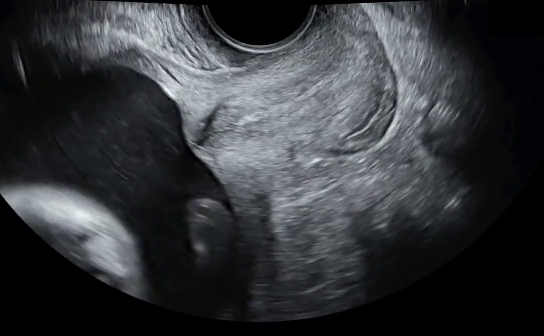

In [6]:
PILImage.create(im)

In [7]:
labels = get_image_files(dataroot_dir/'labels')
labels

(#50) [Path('dataset/labeled_data/labels/0031.png'),Path('dataset/labeled_data/labels/0019.png'),Path('dataset/labeled_data/labels/0042.png'),Path('dataset/labeled_data/labels/0025.png'),Path('dataset/labeled_data/labels/0030.png'),Path('dataset/labeled_data/labels/0014.png'),Path('dataset/labeled_data/labels/0006.png'),Path('dataset/labeled_data/labels/0050.png'),Path('dataset/labeled_data/labels/0001.png'),Path('dataset/labeled_data/labels/0003.png'),Path('dataset/labeled_data/labels/0008.png'),Path('dataset/labeled_data/labels/0022.png'),Path('dataset/labeled_data/labels/0012.png'),Path('dataset/labeled_data/labels/0033.png'),Path('dataset/labeled_data/labels/0046.png'),Path('dataset/labeled_data/labels/0041.png'),Path('dataset/labeled_data/labels/0005.png'),Path('dataset/labeled_data/labels/0020.png'),Path('dataset/labeled_data/labels/0047.png'),Path('dataset/labeled_data/labels/0015.png')...]

In [8]:
lbl = labels[0]; lbl

Path('dataset/labeled_data/labels/0031.png')

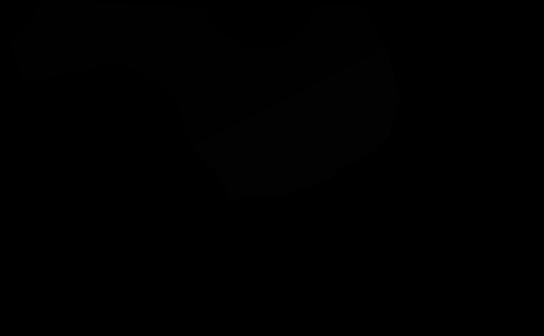

In [9]:
msk = PILMask.create(lbl);msk

 # DataLoaders -> DataLoader(TrainingSet), DataLoader(ValidationSet) - Dataset - x, y - Datablock

In [10]:
np.unique(msk)

array([0, 1, 2], dtype=uint8)

In [11]:
cervical_classes =('background','anterior', 'posterior')

In [12]:
cervcal_datablocks = (ImageBlock, MaskBlock(codes=cervical_classes))
def get_y(x): return(str(x).replace('images', 'labels'))

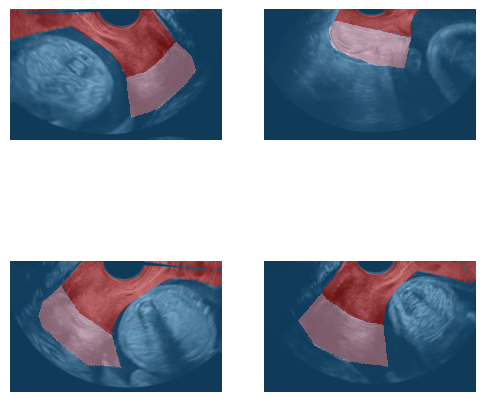

In [13]:
datablock = DataBlock(
    blocks= cervcal_datablocks,
    get_items=get_image_files,
    get_y = get_y,
    batch_tfms=[*aug_transforms(), Normalize.from_stats(*imagenet_stats)])
dls = datablock.dataloaders(dataroot_dir/'images', bs=4)
dls.show_batch()

In [14]:
xb, yb = dls.one_batch()

In [15]:
xb.shape, yb.shape

(torch.Size([4, 3, 336, 544]), torch.Size([4, 336, 544]))

In [16]:
yb.unique()

TensorMask([0, 1, 2], device='cuda:0')

In [17]:
len(dls.train_ds)

40

In [18]:
len(dls.valid_ds)

10

In [19]:
num_classes=3

model = smp.DeepLabV3Plus(
    encoder_name='efficientnet-b5',
    encoder_weights='imagenet',
    in_channels=3,
    classes=num_classes,
    activation=None
)


In [20]:
# Define TverskyLoss
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

def tversky_loss(y_pred, y_true):
    y_true = F.one_hot(y_true, num_classes=num_classes).permute(0, 3, 1, 2).float()
    return TverskyLoss(y_pred, y_true)

def criterion(y_pred, y_true):
    fl = FocalLossFlat(axis=1)(y_pred, y_true)
    tl = tversky_loss(y_pred, y_true)
    
    return 0.5*fl + 0.5*tl

In [21]:
learn = Learner(dls, model, loss_func=FocalLossFlat(axis=1), metrics=[foreground_acc, DiceMulti(axis=1)],opt_func=ranger).to_fp16()

In [22]:
learn.fit_one_cycle(50, 1e-3)

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.554063,0.467334,0.459538,0.259584,00:04
1,0.544348,0.446982,0.456566,0.351355,00:03
2,0.520256,0.409757,0.466021,0.445531,00:03
3,0.480553,0.346666,0.579065,0.558260,00:03
4,0.427404,0.253348,0.580726,0.672643,00:03
5,0.365737,0.188254,0.657348,0.764001,00:03
6,0.306998,0.136515,0.754198,0.821933,00:03
7,0.255937,0.100868,0.733051,0.830857,00:03
8,0.215828,0.087449,0.729194,0.835751,00:03
9,0.181348,0.070408,0.802413,0.871880,00:03


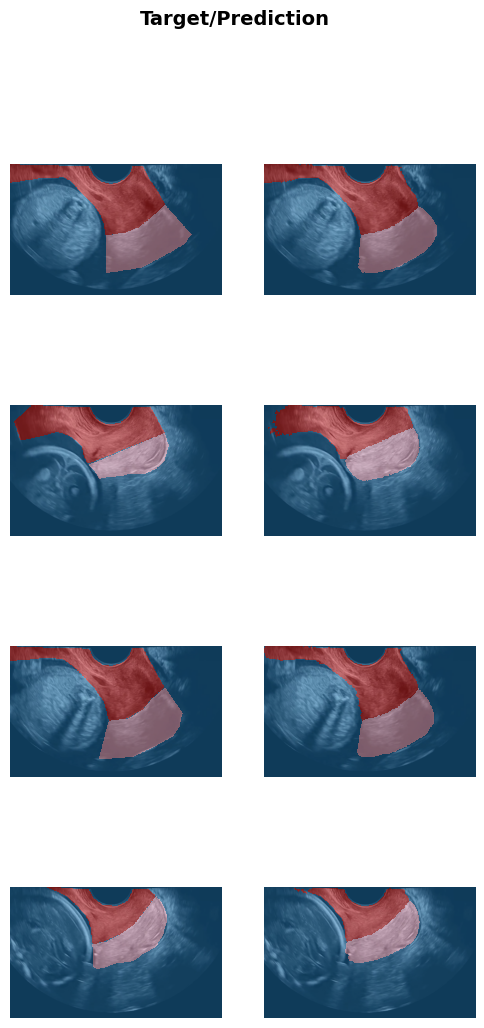

In [23]:
learn.show_results(max_n=4, figsize=(6,12))

In [24]:
learn.unfreeze()
learn.fit_one_cycle(50, slice(1e-3/400, 1e-3/4))

epoch,train_loss,valid_loss,foreground_acc,dice_multi,time
0,0.012980,0.022834,0.926357,0.952032,00:03
1,0.013041,0.022818,0.926814,0.952123,00:03
2,0.013014,0.022750,0.926597,0.952117,00:03
3,0.012878,0.022908,0.926824,0.952042,00:03
4,0.012803,0.023969,0.923677,0.950180,00:03
5,0.012825,0.023006,0.924687,0.951858,00:03
6,0.012645,0.024573,0.916640,0.949928,00:03
7,0.012666,0.024088,0.927980,0.951218,00:04
8,0.012675,0.024968,0.924321,0.950544,00:03
9,0.012792,0.027682,0.908911,0.945745,00:03


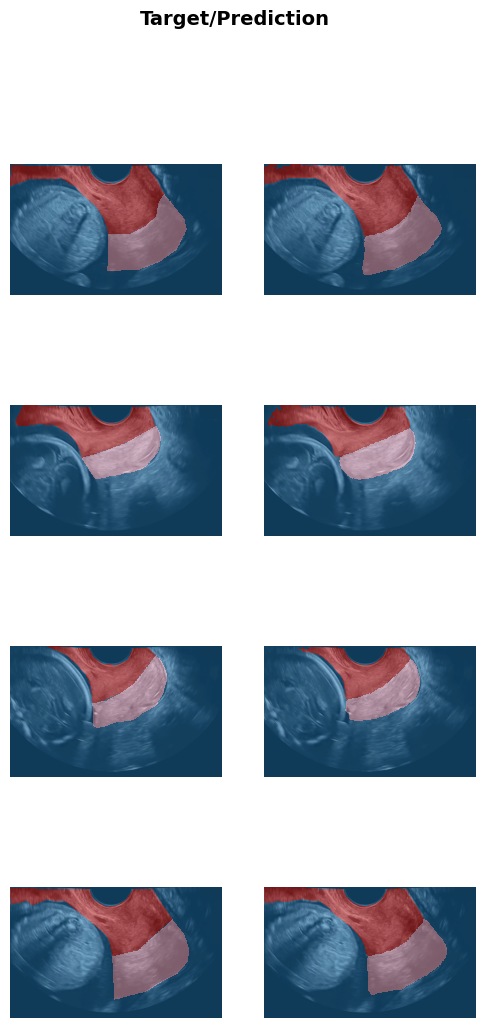

In [25]:
learn.show_results(max_n=4, figsize=(6,12))

In [26]:
learn.export('cervical_baseline_model_v1.pkl')  # Save the trained model

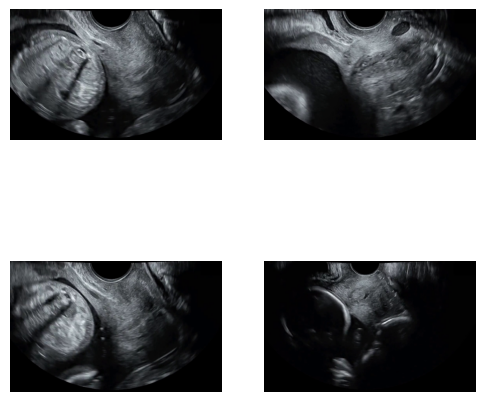

In [27]:
dl = learn.dls.test_dl(
    (Path('dataset/unlabeled_data/images')).ls()
)
dl.show_batch()

In [28]:
preds = learn.get_preds(dl=dl)

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

RuntimeError: Exception occured in `GatherPredsCallback` when calling event `after_batch`:
	DataLoader worker (pid 365826) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.